# <font color='orange'>HEADSPACE</font> 
## Meditation App Free Trial Case Study (Assumed Data)
### A/B Testing (Bayesian Approach)

Headspace app is a virtual teacher/guide that can help people live stress free, happier and healthier life. 

It is based on a simple but brilliant idea of teaching the world to meditate, so that everyone can live a *happier, healthier and more enjoyable life*

Currently, Headspace offers 10 day free trial. 

![](images/hs.png)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

import pymc3 as pm 

from scipy.stats import beta
from scipy.special import beta as beta_func
from scipy.stats import binom

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
/Applications/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Applications/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


**A/B Testing** is comparing 2 versions of a web page to see which one performs betters. 

![ab-testing](images/ab0.png)

eCommerce, News, Media companies want visitors visiting their websites converting from just visitors to something else (purchase/subscription/etc.)

Anything that affects visitor behavior can be A/B tested:
   - Headlines
   - Product Description
   - Paragraph Text (long or short)
   - Links
   - Images
   - Pricing Structures
   - Sale Promotions
   - Free Trial Durations
   - Navigation/Layout
   - User Experience
   - Free or Paid Delivery
   - Etc.
    
#### A/B Testing Process
1. Ask a question
2. Do background research
3. Construct a hypothesis
4. Calculate the number of visitors/day needed to run the test for
5. Test typothesis
6. Analyze data and draw conclusions

**Frequentist approach** - Start with a model's hypothesized parameters and find out how well the data fits a model with the hypothesized parameters.

- Construct Hypothesis
    - $H_0$: No difference between experiment (B variation) and control (A variation)
    - $H_a$: There is a difference between experiment (B variation) and control (A variation)
- Find out if the data provides strong evidence to reject the null hypothesis in favor of an alternative.

Frequentist approach may require large amount of data to analyze and draw conclusions (e.g. big sample size needed and few people visit website)

**Bayesian approach** - Start with data and find out which model parameters best fit the data.

- Start with a prior model (belief) for experiment (B variation) and control (A variation)
- Use data to update posterior model (belief) for experiment (B variation) and control (A variation)
- Using posterior models find out if the experiment (B variation) is better than control (A variation) at some significance level.

## Free Trial Case Study (Assumed Data)

Here I am going to perform an A/B test to test whether **free trial duration** affects visitor subscripton rate.

Lets assume there are 3 trial durations:
- A (Control): 1 week
- B (experiment): 10 days
- C (experiment): 2 weeks

Proportion of visitors subscribing after duration $t$ free trial be $\theta_t$. It is reasonable to assume that the proportion of subscribers after 1 week trial (control) is a value somewhere between 0% and 100% with equal probability, i.e. a uniform distribution $\theta_A \sim Unif(0,1)$. 

$\theta_A$ is a fixed value and the uniform distribution captures uncertainties in its true value. Bayesian approach updates the distribution based on data observed.


$\theta_t \sim Unif(0,1)$, this distribution can be updated based on observed data $D$. If a random visitor subscribes then the observed data point is $y_1 = 1$. Bayes rule updates the distribution (posterior) as follows:

$$P(\theta_t|D) = \frac{P(D|theta_t)P(\theta_t)}{P(D)}$$

## Simple Model

![simple](images/simple.png)

Model summary:
- Observations $y_j$ are randomly 0 or 1 with some likelihood $\theta_t$
- $\theta_t$ (prior) is assumed to be uniformly distributed in range 0 to 1, and $\theta_t$ will be updated based on observed data $D = y_1 = 1, y _2 = 0, y_3 = 0, ...$

Suppose subscription data for 3 trial durations being tested is collected:
- A (Control): 1 week
- B (experiment): 10 days
- C (experiment): 2 weeks

**Data**

| Variant  | Subscriptions  |Free Trial Users |
|---|---|---|
| A (1 week)  | 31  | 210  |
| B (10 days)  |  48 | 190  |
| C (2 weeks)  | 51  | 220  |

In [2]:
"""
This program finds the HDI of a probability density function that is specified 
mathematically in Python.
"""
from scipy.optimize import fmin
from scipy.stats import *

def HDIofICDF(dist_name, credMass=0.95, **args):
    # freeze distribution with given arguments
    distri = dist_name(**args)
    # initial guess for HDIlowTailPr
    incredMass =  1.0 - credMass

    def intervalWidth(lowTailPr):
        return distri.ppf(credMass + lowTailPr) - distri.ppf(lowTailPr)

    # find lowTailPr that minimizes intervalWidth
    HDIlowTailPr = fmin(intervalWidth, incredMass, ftol=1e-8, disp=False)[0]
    # return interval as array([low, high])
    return distri.ppf([HDIlowTailPr, credMass + HDIlowTailPr])

### Bayesian updating for Bernoulli Likelihood and Beta Prior:

Input arguments: 

- Prior shape - Vector of parameter $\alpha, \beta$ values for the prior beta distribution

- Data Vector - Vector of 1's and 0's 

- Credibility Mass - The probability mass of the High Density Interval

Mean proportion of heads: $m = \frac{a}{(a + b)}$ same as mean of Beta$(\theta; \alpha, \beta)$ and the sample size $n = a + b$, solving these for $a$ and $b$ yields: $a = mn$ and $b = \frac{(1-m)}{n}$



$p(\theta|z, N) = \frac{p(z, N|\theta) p(\theta)}{p(z, N)}$

Prior $p(\theta) = Beta(\theta; a, b)$

Evidence p(D) = p(z, N) = $\frac{Beta(z + a, N - z + b)}{Beta(a, b)}$

Likelihood $p(z, N|\theta) = \theta^{z} (1 - \theta)^{N-z}$

We get Posterior $p(\theta|z, N) = Beta(\theta; z + a, N - z + b)$


In [3]:
def bern_beta(prior_shape, data_vec, cred_mass = 0.95):
    
    # Check for errors in input arguments:
    if len(prior_shape) != 2:
        sys.exit('prior_shape must have two components.')
    if any([i < 0 for i in prior_shape]):
        sys.exit('prior_shape must be positive.')
    if any([i != 0 and i != 1 for i in data_vec]):
        sys.exit("data_vec must be a vector of 1's and 0's.")
    if cred_mass <= 0 or cred_mass >= 1:
        sys.exit('cred_mass must be between 0 and 1.')
        
    # Rename prior shape parameters, for convenience
    a = prior_shape[0]
    b = prior_shape[1]
    
    # Create summary values of the data
    z = sum(data_vec[data_vec == 1]) # No. of 1's in the data
    N = len(data_vec) # No. of flips in data_vec
    
    # Calculate posterior shape parameters
    post_shape = [z + a, N - z + b]
    
    # Calculate the evidence p(D) = p(z, N)
    p_data = beta_func(z + a, N - z + b) / beta_func(a, b)
    
    # Construct grid of theta values, used for graphing
    bin_width = 0.005
    theta = np.arange(bin_width / 2, 1 - (bin_width / 2), bin_width)
    
    # Calculate prior at each value of theta
    p_theta = beta.pdf(theta, a, b)
    
    # Calculate the likelihood of the data at each value of theta
    p_data_given_theta = theta**z * (1 - theta)**(N - z)
    
    # Calculate the posterior at each value of theta
    post_a = post_shape[0]
    post_b = post_shape[1]
    p_theta_given_data = beta.pdf(theta, post_a, post_b)
    
    # Determine the limits of the Highest Density Interval
    intervals  = HDIofICDF(beta, cred_mass, a = post_a, b = post_b)
    
    # Plot the results
    plt.figure(figsize=(16, 6))
    plt.subplots_adjust(hspace = 0.5)
    locx = 0.1 # text start location
    
    # Plot the posterior:
    plt.plot(theta, p_theta_given_data)
    plt.xlim(0, 1)
    plt.ylim(0, np.max(p_theta_given_data)*1.2)
    plt.xlabel(r'$\theta$', fontsize = 16)
    plt.ylabel(r'$P(\theta|D)$', fontsize = 16)
    plt.title('Posterior', fontsize = 16)
    locy = np.linspace(0, np.max(p_theta_given_data), 5)
    plt.text(locx, locy[1], r'beta($\theta$;%s,%s)' % (post_a, post_b), fontsize = 16)
    plt.text(locx, locy[2], 'P(D) = %g' % p_data, fontsize = 16) 
    plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

    # Plot the HDI
    plt.text(locx, locy[3], 'Intervals = %.3f - %.3f' % (intervals[0], intervals[1]), fontsize = 16)
    plt.fill_between(theta, 0, p_theta_given_data, 
                     where = np.logical_and(theta > intervals[0],theta < intervals[1]), 
                     color='blue', alpha=0.3)
    
    return post_shape

### Variation A (control):
- Number of subscriptions: 31
- Number of free trial users: 210
- Prior belief is a Uniform distribution: $Beta(\theta; \alpha = 1, \beta = 1)$ is a uniform distribution

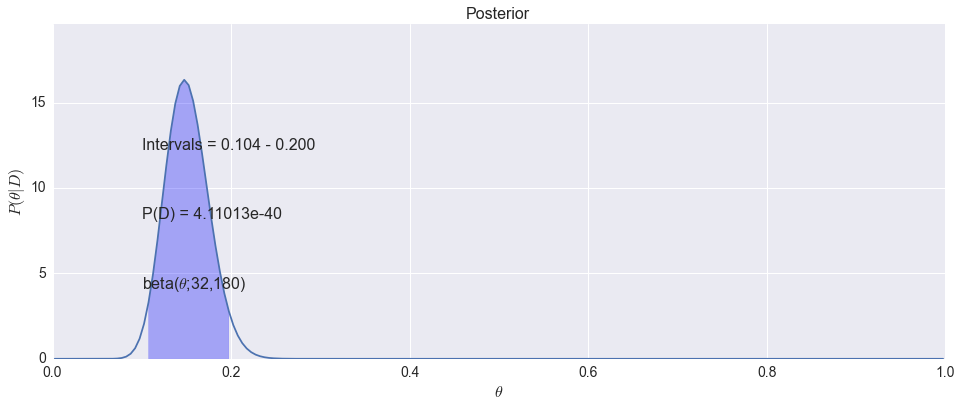

In [4]:
# data: 31 subscribed or 1 and (210 - 31) did not subscribe or 0
data = np.repeat([1, 0], [31, (210 - 31)])
prior = [1, 1]
posterior_A = bern_beta(prior, data)

### Variation B (Experiment):
- Number of subscriptions: 48
- Number of free trial users: 190
- Prior belief is a Uniform distribution: $Beta(\theta; \alpha = 1, \beta = 1)$ is a uniform distribution

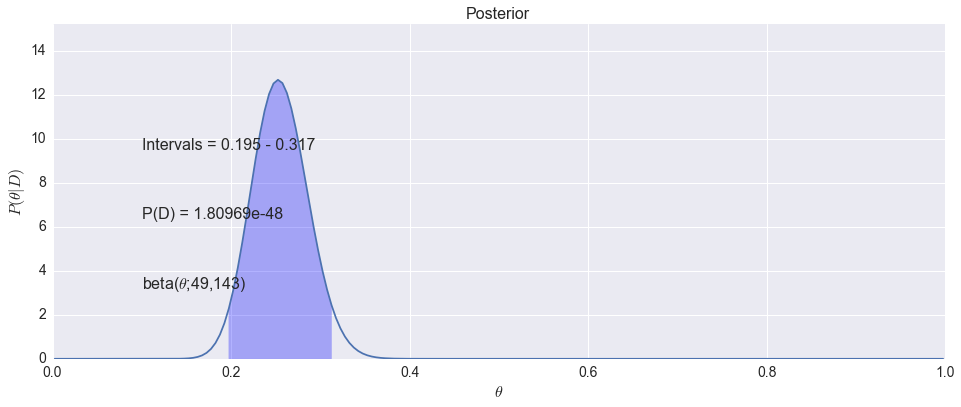

In [5]:
# data: 48 subscribed or 1 and (190 - 48) did not subscribe or 0
data = np.repeat([1, 0], [48, (190 - 48)])
prior = [1, 1]
posterior_B = bern_beta(prior, data)

### Variation C (Experiment):
- Number of subscriptions: 51
- Number of free trial users: 220
- Prior belief is a Uniform distribution: $Beta(\theta; \alpha = 1, \beta = 1)$ is a uniform distribution

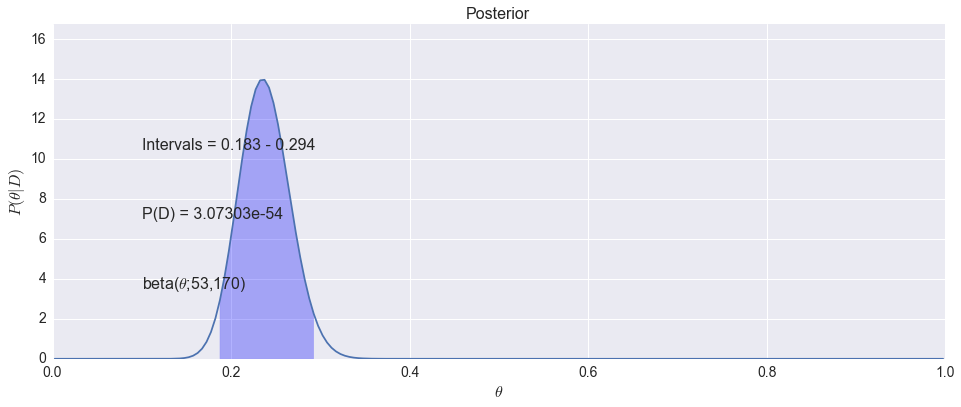

In [6]:
# data: 51 subscribed or 1 and (220 - 51) did not subscribe or 0
data = np.repeat([1, 0], [52, (220 - 51)])
prior = [1, 1]
posterior_C = bern_beta(prior, data)

In [7]:
# Construct grid of theta values, used for graphing
bin_width = 0.005
theta = np.arange(bin_width / 2, 1 - (bin_width / 2), bin_width)

# Calculate P(theta|data)
post_theta_A = beta.pdf(theta, posterior_A[0], posterior_A[1])
post_theta_B = beta.pdf(theta, posterior_B[0], posterior_B[1])
post_theta_C = beta.pdf(theta, posterior_C[0], posterior_C[1])

probabilities = np.hstack((theta, post_theta_A, post_theta_B, post_theta_C)).reshape(4, 200).T
cols = ['theta', 'post_theta_A', 'post_theta_B', 'post_theta_C']

# Create a dataframe
df = pd.DataFrame(probabilities, index = range(len(theta)), columns = cols)

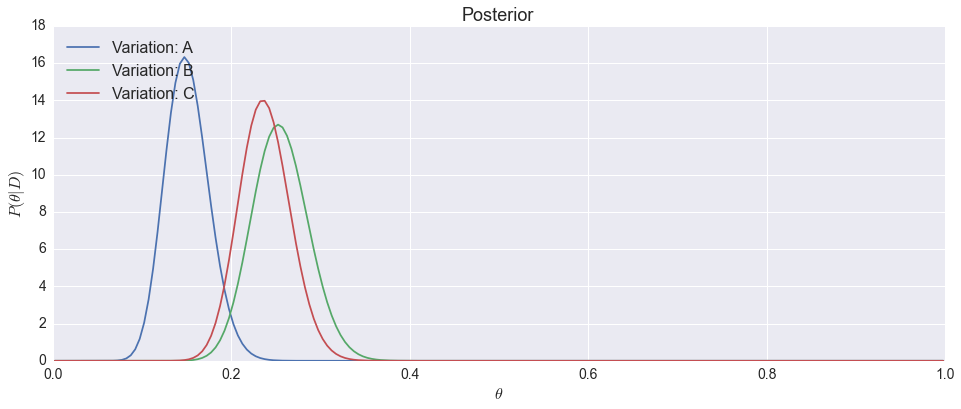

In [8]:
# Plot posteriors
plt.figure(figsize=(16, 6))
plt.plot(df['theta'], df['post_theta_A'])
plt.plot(df['theta'], df['post_theta_B'])
plt.plot(df['theta'], df['post_theta_C'])
plt.xlim(0, 1)
plt.xlabel(r'$\theta$', fontsize = 16)
plt.ylabel(r'$P(\theta|D)$', fontsize = 16)
plt.title('Posterior', fontsize = 18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.legend(['Variation: A', 'Variation: B', 'Variation: C'], loc='upper left', fontsize = 16)
#plt.legend([r'$P(\theta_A|D)$', r'$P(\theta_B|D)$', r'$P(\theta_C|D)$'], loc='upper left', fontsize = 16)

According to the simple uniform prior model (visually from the above plot), there is more than a 95% chance that variations B and C are better than variation A, i.e. Users experiencing 10 day or 2 weeks free trial are subscribing more compared to users experiencing 1 week free trial.

Here 3 proportions are being compared, this results in 3 pairwise comparisons. Thus there more than 5% chance of making an error. As more proportions are compared simultaneously, the risk of making a random error increases dramatically. Bonferroni correction is used by frequentists to deal with multiple comparisions are performed simultaneously. The confidence required to do 3 comparisons is $1-0.05/3 = 0.9833$, i.e. 98.33 % confidence for each comparision. This means that more data is needed to be collected.

For Bayesian modeling performing multiple comparisons simultaneously does not cause problems. The approach is to use a model with shrinkage instead of collecting large amount of data. [[Gelman et.al](http://www.stat.columbia.edu/~gelman/research/published/multiple2f.pdf)]

## Hierarchical Bayesian Modeling

- Basic Idea: Assume the parameters of each experiment (variation) is drawn from a shared underlying distribution, whose parameters are estimated as part of the inference. This has the effect of "shrinking" variations closer to the mean. [[Shrinkage in Hierarchical Model](http://doingbayesiandataanalysis.blogspot.com/2012/11/shrinkage-in-multi-level-hierarchical.html)]

![hbm](images/hbm.png)

Assumption: $\theta_A$, $\theta_B$, $\theta_C$ share a common distribution.

In the simple model all the $\theta_t$'s were clustered within a small interval (extremely unlikely that uniformly sampled proportion are in a small interval). To quantify this uncertainty another model is made for the distribution of means and it is updated based on observed data.

**Hierarchical Model Summary:**
- $\theta_t$'s are drawn from a beta distribution with mean $\omega$ and spread $\kappa$
- This model assumes that each visitor experiencing free trial duration $t$ has a chance $\theta_t$ to subscribe. Each proportion comes from a common distribution $Beta(\omega, \kappa)$
- $\omega$ (prior) is assumed to be uniformly distributed in range 0 to 1
- $\kappa$ (prior) is assumed to be drawn from a Gamma distribution.
- This hierarchical model will give more accurate estimates of each $\theta_t$
- This model shrinks $\theta_t$'s toward their common mean

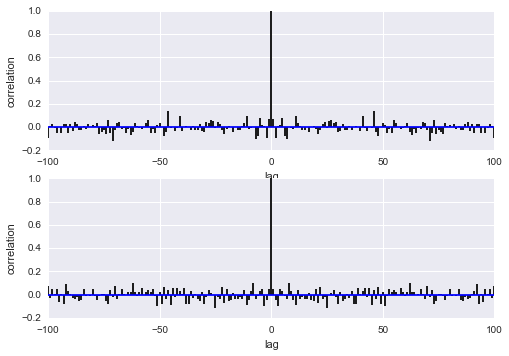

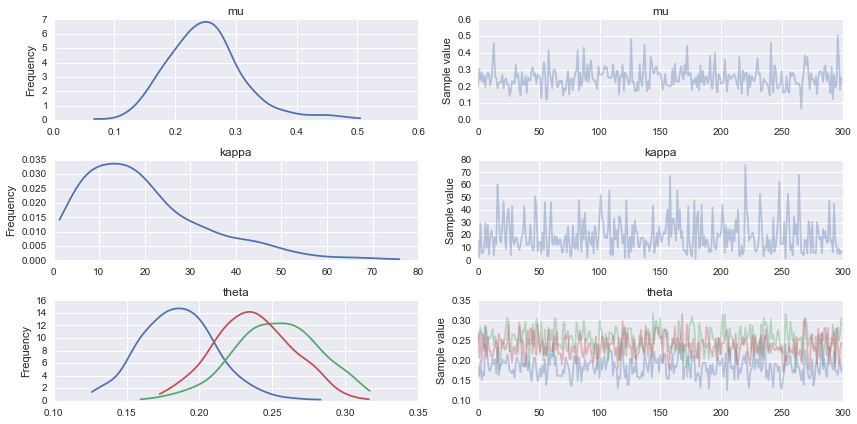

In [9]:
# Doing Bayesian Data Analysis Problem 9.1 Code

N = [210, 190, 220] # Number of flips per coin
z = [38, 48, 52] # Number of heads per coin

# Arrange the data in a convenient way to feed the PyMC model
coin = [] # List/Vector index for each coin (from 0 to number of coins)
y = [] # List/Vector with head (1) or tails (0) for each flip

for i, flips in enumerate(N):
    heads = z[i]
    if heads > flips:
        sys.exit("The number of heads can't be greater than the number of flip")
    else:
        # Adding elements to list: e.g. [A] * 2 + [B] * 3 = [A, A, B, B, B]
        y = y + [1] * heads + [0] * (flips - heads)
        # Identity of coin
        coin = coin + [i] * flips
        
# Specify the model in PyMC
with pm.Model() as model:
    
    # Define hyperparameters
    mu = pm.Beta('mu', 1, 1) # Uniform
    kappa = pm.Gamma('kappa', 1, 0.1)
    
    # Define the prior
    theta = pm.Beta('theta', mu * kappa, (1 - mu) * kappa, shape = len(N))
    
    # Define the likelihood
    y = pm.Bernoulli('y', p = theta[coin], observed = y)
    
    # Generate a MCMC chain
    step = pm.Metropolis()
    trace = pm.sample(5000, step, progressbar = False)

# Check the results
burn_in = 2000 # Posterior sample to discard
thin = 10 # Posterior sample to discard

# Print summary for each trace
#pm.summary(trace[burn_in::thin])
#pm.summary(trace)

# Check for mixing and autocorrelation
pm.autocorrplot(trace[burn_in::thin], vars = [mu, kappa])
#pm.autocorrplot(trace, vars = [mu, kappa])

# Plot KDE and sampled values for each parameter
pm.traceplot(trace[burn_in::thin])
#pm.traceplot(trace)

# Create arrays with the posterior sample
theta1_sample = trace['theta'][:,0][burn_in::thin]
theta2_sample = trace['theta'][:,1][burn_in::thin]
theta3_sample = trace['theta'][:,2][burn_in::thin]
mu_sample = trace['mu'][burn_in::thin]
kappa_sample = trace['kappa'][burn_in::thin]

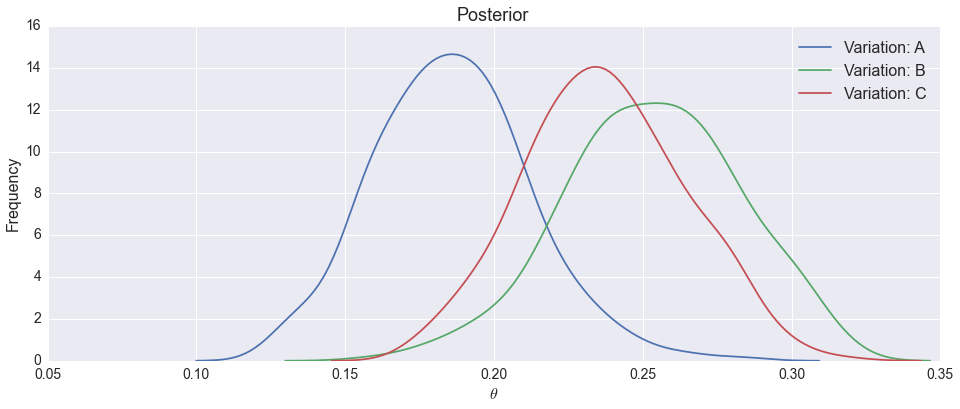

In [10]:
# Plot posteriors
plt.figure(figsize=(16, 6))

sns.distplot(theta1_sample, hist = False, rug = False, label = 'Variation: A')
sns.distplot(theta2_sample, hist = False, rug = False, label = 'Variation: B')
sns.distplot(theta3_sample, hist = False, rug = False, label = 'Variation: C')

plt.xlabel(r'$\theta$', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Posterior', fontsize = 18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.legend(fontsize = 16)

In [14]:
duration = ['1 week free trial is ', '10 days free trial is ', '2 weeks free trial is ']
txt = 'Proportions of users subscribing after '
print txt + duration[0] + str(np.mean(theta1_sample))
print txt + duration[1] + str(np.mean(theta2_sample))
print txt + duration[2] + str(np.mean(theta3_sample))

Proportions of users subscribing after 1 week free trial is 0.185861068736
Proportions of users subscribing after 10 days free trial is 0.253141919477
Proportions of users subscribing after 2 weeks free trial is 0.237092651261


#### Based on the A/B Test using Bayesian Approach it is obvious that proportion of users subscribing after 10 days free trial offer is much better and higher than the current (assumed) 1 week free trial offer.

### References and Resources

- The analysis done above is based on [this particular blog on "How We Avoid A/B Testing Errors with Shrinkage" by Martin Loncaric](http://eng.wealthfront.com/2015/10/29/how-we-avoid-ab-testing-errors-with-shrinkage/) 
- [Doing Bayesian Data Analysis Book](http://www.indiana.edu/~kruschke/DoingBayesianDataAnalysis/)


**Resources**
- [A/B Testing Rigorously](http://elem.com/~btilly/ab-testing-multiple-looks/part1-rigorous.html#use-this)  
- [How to calculate sample size](https://vwo.com/blog/how-to-calculate-ab-test-sample-size/)  
- [A/B Testing Resources](https://www.quicksprout.com/2014/11/05/ab-testing-for-beginners-70-resources-to-get-you-started/)  
- [Statistical Analysis and A/B Testing](http://20bits.com/article/statistical-analysis-and-ab-testing)  
- [How Not To Run An A/B Test](http://www.evanmiller.org/how-not-to-run-an-ab-test.html)  
- [A/B Testing Basic Info](https://www.smashingmagazine.com/2010/06/the-ultimate-guide-to-a-b-testing/)  
- [Sample Size Calculator](http://www.evanmiller.org/ab-testing/sample-size.html)  